In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

np.random.seed(2)

In [55]:
class MinMaxScaler:
    def __init__(self):
        self.data = None
        self.normalized_data = None

    def fit(self, data):
        self.data = data

    def transform(self):
        if self.normalized_data is None:
            return (self.data - np.min(self.data)) / (
                np.max(self.data) - np.min(self.data)
            )
        return self.normalized_data

    def fit_transform(self, data):
        self.data = data
        self.normalized_data = (self.data - np.min(self.data)) / (
            np.max(self.data) - np.min(self.data)
        )
        return self.normalized_data

In [56]:
class StandardScaler:
    def __init__(self):
        self.data = None
        self.normalized_data = None

    def fit(self, data):
        self.data = data

    def transform(self):
        if self.normalized_data is None:
            return (self.data - np.mean(self.data)) / np.std(self.data)
        return self.normalized_data

    def fit_transform(self, data):
        self.data = data
        self.normalized_data = (self.data - np.mean(self.data)) / np.std(self.data)
        return self.normalized_data

In [57]:
class KMeans:
    def __init__(self, k=2):
        self.k = k
        self.centroids = None
        self.clusters = None
        self.inertia_ = None

    @staticmethod
    def euclidean_distance(data_point, centroids):
        return np.sqrt(np.sum((centroids - data_point) ** 2, axis=1))

    def fit(self, X, max_iter=200):
        self.centroids = X[np.random.choice(len(X), size=self.k, replace=False)]
        # self.centroids = np.random.uniform(
        #     np.amin(X, axis=0), np.amax(X, axis=0), size=(self.k, X.shape[1])
        # )
        self.clusters = np.zeros(len(X))
        for _ in range(max_iter):
            y = []

            for data_point in X:
                distances = KMeans.euclidean_distance(data_point, self.centroids)
                y.append(np.argmin(distances))

            y = np.array(y)

            cluster_centers = []

            for i in range(self.k):
                if len(X[y == i]) == 0:
                    # cluster_centers.append(
                    #     np.random.uniform(
                    #         np.amin(X, axis=0),
                    #         np.amax(X, axis=0),
                    #     )
                    # )
                    cluster_centers.append(X[np.random.choice(len(X))])

                else:
                    cluster_centers.append(np.mean(X[y == i], axis=0))
            self.inertia_ = np.sum(
                [
                    np.sum(np.sqrt((X[y == j] - self.centroids[j]) ** 2))
                    for j in range(self.k)
                ]
            )

            num_points_change = np.sum(y != self.clusters)

            if num_points_change <= 1:
                break
            else:
                self.centroids = np.array(cluster_centers)
                self.clusters = y
        return y

    def DBI(self, X, y):
        self.S = np.array(
            [
                np.mean(np.sqrt(np.sum((X[y == j] - self.centroids[j]) ** 2, axis=1)))
                for j in range(self.k)
            ]
        )

        dbi_sum = 0.0
        for i in range(self.k):
            max_ratio = 0.0
            for j in range(self.k):
                if j != i:
                    ratio = (self.S[i] + self.S[j]) / np.linalg.norm(
                        self.centroids[i] - self.centroids[j]
                    )
                    max_ratio = max(max_ratio, ratio)

            dbi_sum += max_ratio
        dbi = dbi_sum / self.k

        return dbi

    def accuracy(self, true_labels) -> float:
        unique_clusters = np.unique(self.clusters)
        cluster_labels = {}

        for cluster in unique_clusters:
            cluster_mask = self.clusters == cluster
            majority_label = np.argmax(np.bincount(true_labels[cluster_mask]))
            cluster_labels[cluster] = majority_label

        assigned_labels = np.array(
            [cluster_labels[cluster] for cluster in self.clusters]
        )

        return np.sum(true_labels == assigned_labels) / len(assigned_labels)

In [58]:
class GMM:
    def __init__(self, k, max_iter=10):
        self.k = k
        self.max_iter = int(max_iter)

    def initialize(self, X):
        self.shape = X.shape
        self.n, self.m = self.shape

        self.phi = np.full(shape=self.k, fill_value=1 / self.k)
        self.weights = np.full(shape=self.shape, fill_value=1 / self.k)

        kmeans = KMeans(self.k)
        kmeans.fit(X)
        self.mu = kmeans.centroids

        self.sigma = [np.cov(X.T) for _ in range(self.k)]

    def e_step(self, X):
        self.weights = self.predict_proba(X)
        self.phi = self.weights.mean(axis=0)

    def m_step(self, X, epsilon=1e-6):
        for i in range(self.k):
            weight = self.weights[:, [i]]
            total_weight = weight.sum()
            self.mu[i] = (X * weight).sum(axis=0) / total_weight

            cov_matrix = np.cov(
                X.T, aweights=(weight / total_weight).flatten(), bias=True
            )
            self.sigma[i] = cov_matrix + epsilon * np.identity(cov_matrix.shape[0])

    def fit(self, X, tol=1e-6):
        prev_log_likelihood = 0
        self.initialize(X)

        for _ in range(self.max_iter):
            self.e_step(X)
            self.m_step(X)

            log_likelihood = self.log_likelihood(X).sum()
            if np.abs(log_likelihood - prev_log_likelihood) < tol:
                break

            prev_log_likelihood = log_likelihood

    def predict_proba(self, X):
        likelihood = np.zeros((X.shape[0], self.k))
        for i in range(self.k):
            distribution = multivariate_normal(mean=self.mu[i], cov=self.sigma[i])
            likelihood[:, i] = distribution.pdf(X)

        numerator = likelihood * self.phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        weights = numerator / denominator
        return weights

    def predict(self, X):
        weights = self.predict_proba(X)
        return np.argmax(weights, axis=1)

    def accuracy(self, true_labels, pred_labels) -> float:
        unique_clusters = np.unique(pred_labels)
        cluster_labels = {}

        for cluster in unique_clusters:
            cluster_mask = pred_labels == cluster
            majority_label = np.argmax(np.bincount(true_labels[cluster_mask]))
            cluster_labels[cluster] = majority_label

        assigned_labels = np.array([cluster_labels[cluster] for cluster in pred_labels])

        return np.sum(true_labels == assigned_labels) / len(assigned_labels)

    def bic(self, X):
        log_likelihood = self.log_likelihood(X)
        n = X.shape[0]

        bic = -2 * np.sum(log_likelihood) + self.k * np.log(n)
        return bic

    def aic(self, X):
        log_likelihood = self.log_likelihood(X)
        num_params = self.k * (self.m + self.m + 1)

        aic = -2 * np.sum(log_likelihood) + 2 * num_params
        return aic

    def log_likelihood(self, X):
        likelihood = np.zeros((X.shape[0], self.k))
        for i in range(self.k):
            distribution = multivariate_normal(mean=self.mu[i], cov=self.sigma[i])
            likelihood[:, i] = distribution.pdf(X)

        log_likelihood = np.log(np.sum(self.phi * likelihood, axis=1) + 1e-10)
        return log_likelihood

In [59]:
class Dataset:
    def __init__(self, path):
        self.path = path

    def load(self) -> None:
        self.df = pd.read_csv(self.path)
        self.X = self.df.iloc[:, :-1].values
        self.y = self.df.iloc[:, -1].values

In [60]:
class PCA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.eigenvalues = None
        self.eigenvectors = None
        self.explained_variance_ = None

    def fit(self, X):
        mean = np.mean(X, axis=0)
        X = X - mean

        cov = np.cov(X.T)

        self.eigenvalues, eignvectors = np.linalg.eigh(cov)

        self.eigenvectors = eignvectors.T

        if type(self.n_components) is float:
            sum_ = np.sum(self.eigenvalues[np.argsort(self.eigenvalues)[::-1]])
            nor = self.eigenvalues / sum_
            cumulative = 0

            for i, value in enumerate(nor[np.argsort(nor)[::-1]]):
                cumulative += value
                if cumulative > self.n_components:
                    break

            self.explained_variance_ = np.sort(self.eigenvalues)[::-1][:i]
            self.components = self.eigenvectors[np.argsort(self.eigenvalues)[::-1][:i]]

        else:
            self.explained_variance_ = np.sort(self.eigenvalues)[::-1][
                : self.n_components
            ]
            self.components = self.eigenvectors[
                np.argsort(self.eigenvalues)[::-1][: self.n_components]
            ]

    def transform(self, X):
        mean = np.mean(X, axis=0)
        X = X - mean

        return np.dot(X, self.components.T)

    def reconstruct(self, X):
        mean = np.mean(X, axis=0)
        X = X - mean
        return (
            np.dot(np.dot(X, self.components.T), np.linalg.pinv(self.components.T))
            + mean
        )

## 1. Load the given dataset (“Spellman.csv“).

In [115]:
path = "./datasets/Spellman.csv"
df = pd.read_csv(path)

## 2. for PCA components in range (2,10) and number of clusters (3,4), find the best configuration in term of DBI. (you will have 4 best configuration at last.)

In [102]:
best_configurations = []
for n_components in range(2, 11):
    for n_clusters in range(3, 5):
        pca = PCA(n_components=n_components)
        pca.fit(df.iloc[:, 1:].values)
        pca_result = pca.transform(df.iloc[:, 1:].values)

        kmeans = KMeans(n_clusters)
        kmeans_pred = kmeans.fit(pca_result)
        kmeans_dbi = kmeans.DBI(pca_result, kmeans_pred)

        gmm = GMM(n_clusters)
        gmm.fit(pca_result)
        bic_gmm = gmm.bic(pca_result)
        configuration = (n_components, n_clusters, kmeans_dbi,bic_gmm)
        best_configurations.append(configuration)

In [103]:
best = sorted(best_configurations, key=lambda x: (x[2],x[3]))[:4]

## 3. the configuration can be like (PCA component , number of clusters(K-means and GMM) , DBIscore)


In [116]:
config_df = pd.DataFrame(best, columns=["Components", "Cluster", "DBI", "BIC"])
config_df

,Components,Cluster,DBI,BIC
0,2,4,0.930082,22523.601211
1,2,3,0.955920,22520.415166
2,3,3,1.232711,30393.737878
3,3,4,1.249952,30266.087228


## 4. Visualize your best configurations in 3D.

2D

In [124]:
pca = PCA(n_components=config_df["Components"][0])
kmeans = KMeans(config_df["Cluster"][0])

In [118]:
pca.fit(df.iloc[:, 1:].values)
pca_result = pca.transform(df.iloc[:, 1:].values)

In [126]:
y_pred = kmeans.fit(pca_result)

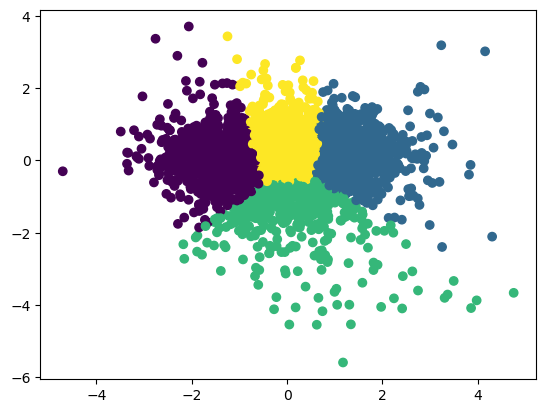

In [128]:
plt.scatter(pca_result[:, 0], pca_result[:,1],c=y_pred)
plt.show()

3D

In [129]:
pca = PCA(n_components=config_df["Components"][2])
kmeans = KMeans(config_df["Cluster"][2])

In [130]:
pca.fit(df.iloc[:, 1:].values)
pca_result = pca.transform(df.iloc[:, 1:].values)

In [131]:
y_pred = kmeans.fit(pca_result)

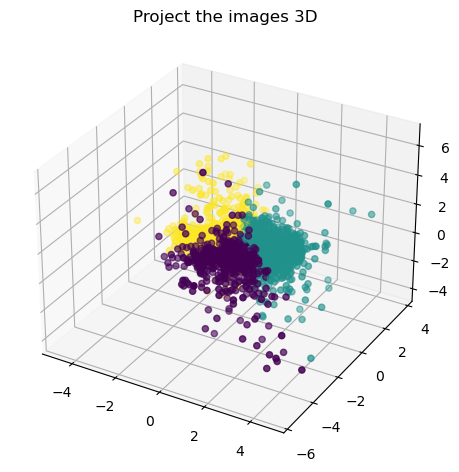

In [132]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=y_pred)
plt.grid()
plt.title("Project the images 3D")
plt.tight_layout()
plt.show()